In [1]:
# ===============================
# 📌 Base Setup Cell (PNG + single JSON)
# ===============================

import os
import glob
import json

# ▶️ EDIT THESE ONLY
IMG_DIR = "/kaggle/input/donutnotebook/images/images"   # folder that contains PNGs
ANN_FILE = "/kaggle/input/donutnotebook/project-14-at-2025-08-28-01-36-5fe328fa.json"  # single JSON export file
OUTPUT_DIR = "/kaggle/working/dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Collect image files ---
image_files = glob.glob(os.path.join(IMG_DIR, "*.png"))
print("=== Paths ===")
print(f"Images root: {IMG_DIR}")
print(f"Labels file: {ANN_FILE}")
print(f"Output dir : {OUTPUT_DIR}\n")

print("=== Counts ===")
print(f"Found {len(image_files)} image(s)")
print(f"Found annotation file: {os.path.exists(ANN_FILE)}\n")

# Preview a few
print("Sample images:")
for p in image_files[:5]:
    print(" -", os.path.basename(p))

print("\nAnnotation file:")
print(" -", ANN_FILE)


=== Paths ===
Images root: /kaggle/input/donutnotebook/images/images
Labels file: /kaggle/input/donutnotebook/project-14-at-2025-08-28-01-36-5fe328fa.json
Output dir : /kaggle/working/dataset

=== Counts ===
Found 395 image(s)
Found annotation file: True

Sample images:
 - resume_253_page_1.png
 - resume_039_page_1.png
 - resume_222_page_2.png
 - resume_042_page_2.png
 - resume_005_page_1.png

Annotation file:
 - /kaggle/input/donutnotebook/project-14-at-2025-08-28-01-36-5fe328fa.json


In [2]:
# ===============================
# 📌 Cell 2: Parse Label Studio JSON (sections per image, relative %)
# ===============================

import os, json

with open(ANN_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

tasks = data["tasks"] if isinstance(data, dict) and "tasks" in data else data
assert isinstance(tasks, list), "Expected a list of tasks"

# sections_by_image[basename] = list of {'label', 'rel':[x,y,w,h], 'orig_size':(W,H)|None}
sections_by_image = {}

for t in tasks:
    img_path = (t.get("data", {}) or {}).get("image") or ""
    basename = os.path.basename(img_path)
    if not basename:
        continue

    all_results = []
    for ann in (t.get("annotations") or t.get("completions") or []):
        all_results.extend(ann.get("result", []) or [])

    items = []
    W = H = None
    for r in all_results:
        v = r.get("value", {}) or {}
        labs = v.get("rectanglelabels") or v.get("labels")
        if not labs: 
            continue
        if "original_width" in v and "original_height" in v:
            W, H = v["original_width"], v["original_height"]
        items.append({
            "label": labs[0],
            "rel": [float(v["x"]), float(v["y"]), float(v["width"]), float(v["height"])],  # in %
        })

    if items:
        sections_by_image[basename] = {
            "orig_size": (W, H) if (W and H) else None,
            "items": items
        }

print("Parsed images with sections:", len(sections_by_image))
print("One example:", next(iter(sections_by_image.keys()), None))


Parsed images with sections: 395
One example: 80e3dd7f-resume_001_page_1.png


In [9]:
# ===============================
# 📌 Cell 3: Group pages by resume ID
# ===============================

import re
from collections import defaultdict

id_re = re.compile(r"resume_(\d+)_page_(\d+)\.png$", re.IGNORECASE)
groups = defaultdict(list)   # resume_id -> [("page_num", "basename")]

for bn in sections_by_image.keys():
    m = id_re.search(bn)
    if not m: 
        continue
    rid, page = m.group(1), int(m.group(2))
    groups[rid].append((page, bn))

# sort and keep just basenames
for rid in list(groups.keys()):
    groups[rid] = [bn for _, bn in sorted(groups[rid])]

print("Unique resumes:", len(groups))
ex_rid = next(iter(groups.keys()), None)
if ex_rid:
    print("Example group:", ex_rid, "->", groups[ex_rid][:3])


Unique resumes: 281
Example group: 001 -> ['80e3dd7f-resume_001_page_1.png']


In [3]:
# ===============================
# 📌 Cell 4: Install & init EasyOCR (FR only)
# ===============================

!pip -q install easyocr

import torch, easyocr
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch CUDA available:", torch.cuda.is_available())

# French only (handles most EN fine too)
reader = easyocr.Reader(['fr'], gpu=(DEVICE == "cuda"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00:00:0100:01
Torch CUDA available: True


In [5]:
# ===============================
# 📌 Cell 5a: Verify mapping from JSON basenames → actual files
# ===============================

import os, glob

# Index all real images by basename
real_imgs = {}
for p in glob.glob(os.path.join(IMG_DIR, "*.png")):
    real_imgs[os.path.basename(p)] = p

json_basenames = list(sections_by_image.keys())
missing = [bn for bn in json_basenames if bn not in real_imgs]

print("Basenames in JSON:", len(json_basenames))
print("Actual PNGs in IMG_DIR:", len(real_imgs))
print("Missing (in JSON but not found in IMG_DIR):", len(missing))
print("Sample missing:", missing[:5])


Basenames in JSON: 395
Actual PNGs in IMG_DIR: 395
Missing (in JSON but not found in IMG_DIR): 395
Sample missing: ['80e3dd7f-resume_001_page_1.png', '4135e312-resume_002_page_1.png', '8b8903f2-resume_002_page_2.png', 'a87bc545-resume_003_page_1.png', '565a2d8e-resume_003_page_2.png']


In [7]:
# ===============================
# 📌 Cell 5a: Normalize JSON basenames (strip prefixes)
# ===============================
import re

def norm_bn(bn: str) -> str:
    m = re.search(r'(resume_\d+_page_\d+\.png)$', bn, re.IGNORECASE)
    return m.group(1) if m else bn

sections_by_image_norm = {}
collisions = 0

for bn, payload in sections_by_image.items():
    nbn = norm_bn(bn)
    if nbn in sections_by_image_norm:
        collisions += 1
        # merge items if duplicated
        a = sections_by_image_norm[nbn].get("items", [])
        b = payload.get("items", [])
        sections_by_image_norm[nbn]["items"] = a + b
        if (not sections_by_image_norm[nbn].get("orig_size")) and payload.get("orig_size"):
            sections_by_image_norm[nbn]["orig_size"] = payload["orig_size"]
    else:
        sections_by_image_norm[nbn] = payload

print("JSON entries (raw):", len(sections_by_image))
print("JSON entries (normalized):", len(sections_by_image_norm))
print("Merged collisions:", collisions)
print("Sample key:", next(iter(sections_by_image_norm.keys()), None))


JSON entries (raw): 395
JSON entries (normalized): 395
Merged collisions: 0
Sample key: resume_001_page_1.png


In [8]:
# ===============================
# 📌 Cell 5b: Check matches & build OCR targets
# ===============================
import os, glob

# Index actual PNGs
real_pngs = {os.path.basename(p): p for p in glob.glob(os.path.join(IMG_DIR, "*.png"))}

# Missing in disk or extras on disk
missing_in_disk = [bn for bn in sections_by_image_norm.keys() if bn not in real_pngs]
extras_on_disk  = [bn for bn in real_pngs.keys() if bn not in sections_by_image_norm]

# Resolve OCR targets (only matched files)
targets = [real_pngs[bn] for bn in sections_by_image_norm.keys() if bn in real_pngs]

print("Normalized JSON entries:", len(sections_by_image_norm))
print("Actual PNG files      :", len(real_pngs))
print("→ Missing on disk     :", len(missing_in_disk))
print("→ Extra PNGs on disk  :", len(extras_on_disk))
print("OCR targets           :", len(targets))
print("Sample target:", os.path.basename(targets[0]) if targets else "—")

# Optional peeks
print("Sample missing:", missing_in_disk[:5])
print("Sample extras :", extras_on_disk[:5])


Normalized JSON entries: 395
Actual PNG files      : 395
→ Missing on disk     : 0
→ Extra PNGs on disk  : 0
OCR targets           : 395
Sample target: resume_001_page_1.png
Sample missing: []
Sample extras : []


In [9]:
# ===============================
# 📌 Cell 5c: OCR on targets (cached)
#  - Uses EasyOCR reader you initialized earlier
# ===============================
import os, json
from PIL import Image

OCR_DIR = os.path.join(OUTPUT_DIR, "ocr")
os.makedirs(OCR_DIR, exist_ok=True)

def ocr_one(image_path):
    results = reader.readtext(image_path, detail=1, paragraph=False)
    words, boxes, confs = [], [], []
    with Image.open(image_path) as im:
        W, H = im.size
    for poly, text, conf in results:
        text = (text or "").strip()
        if not text:
            continue
        xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
        x1, y1 = max(0, min(xs)), max(0, min(ys))
        x2, y2 = min(W, max(xs)), min(H, max(ys))
        if x2 <= x1 or y2 <= y1:
            continue
        words.append(text)
        boxes.append([int(x1), int(y1), int(x2), int(y2)])
        confs.append(float(conf))
    return {"words": words, "boxes_px": boxes, "size": [W, H], "confs": confs}

processed = skipped = 0
for img_path in targets:
    bn = os.path.basename(img_path).replace(".png", ".json")
    out_fp = os.path.join(OCR_DIR, bn)
    if os.path.exists(out_fp):
        skipped += 1
        continue
    data = ocr_one(img_path)
    with open(out_fp, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False)
    processed += 1

print(f"OCR complete → New: {processed} | Cached: {skipped} | Total: {len(targets)}")


OCR complete → New: 395 | Cached: 0 | Total: 395


In [10]:
# ===============================
# 📌 Cell 6: Build label set + BIO tags
# ===============================
from itertools import chain

# Collect raw section names from JSON
section_names = sorted({it["label"] 
                        for v in sections_by_image_norm.values() 
                        for it in v["items"]})

# BIO tag list (LayoutLMv3-style)
labels = ["O"] + list(chain.from_iterable((f"B-{n}", f"I-{n}") for n in section_names))

label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

print("Sections:", section_names)
print("Num labels (BIO+O):", len(labels))
print("Example mapping:", {k: label2id[k] for k in labels[:6]})


Sections: ['CONTACT', 'EDUCATION', 'EXPERIENCE', 'LANGUES', 'OTHERS', 'PERSONAL_INFO', 'PROJECTS/certifications', 'SKILLS', 'SUMMARY']
Num labels (BIO+O): 19
Example mapping: {'O': 0, 'B-CONTACT': 1, 'I-CONTACT': 2, 'B-EDUCATION': 3, 'I-EDUCATION': 4, 'B-EXPERIENCE': 5}


In [11]:
# ===============================
# 📌 Cell 7: Align words → BIO tags using section rectangles
# ===============================
import os, json

def rel_to_abs_xyxy(rel, img_w, img_h, orig_size=None):
    # rel = [x%, y%, w%, h%] from Label Studio
    x, y, w, h = rel
    # If LS stored original image size different from current OCR image size, scale via orig_size
    if orig_size:
        oW, oH = orig_size
        # convert rel% to original px, then scale to current
        X1o, Y1o = (x/100.0)*oW, (y/100.0)*oH
        W0,  H0  = (w/100.0)*oW, (h/100.0)*oH
        X2o, Y2o = X1o+W0, Y1o+H0
        sx, sy = img_w/float(oW), img_h/float(oH)
        return [int(X1o*sx), int(Y1o*sy), int(X2o*sx), int(Y2o*sy)]
    else:
        X1, Y1 = (x/100.0)*img_w, (y/100.0)*img_h
        X2, Y2 = X1 + (w/100.0)*img_w, Y1 + (h/100.0)*img_h
        return [int(X1), int(Y1), int(X2), int(Y2)]

def center_inside(box, region):
    # box, region = [x1,y1,x2,y2]
    cx = (box[0]+box[2]) / 2.0
    cy = (box[1]+box[3]) / 2.0
    return (region[0] <= cx <= region[2]) and (region[1] <= cy <= region[3])

# Build per-page aligned examples (kept in memory for now)
aligned_pages = {}  # basename -> dict(words, boxes_px, tags, size)

for img_path in targets:
    bn = os.path.basename(img_path)
    ocr_fp = os.path.join(OUTPUT_DIR, "ocr", bn.replace(".png", ".json"))
    if not os.path.exists(ocr_fp):
        continue

    with open(ocr_fp, "r", encoding="utf-8") as f:
        ocr = json.load(f)

    words = ocr["words"]
    boxes = ocr["boxes_px"]
    W, H  = ocr["size"]

    # Build section boxes in ABS pixels
    sec_meta = sections_by_image_norm.get(bn, {"items": [], "orig_size": None})
    orig_size = tuple(sec_meta["orig_size"]) if sec_meta.get("orig_size") else None
    regions = [(it["label"], rel_to_abs_xyxy(it["rel"], W, H, orig_size)) for it in sec_meta["items"]]

    # Assign BIO per word via center-inside; new region → B-, continuation → I-
    tags = []
    active_label = None
    for wbox in boxes:
        label_here = None
        for lab, rbox in regions:
            if center_inside(wbox, rbox):
                label_here = lab
                break
        if label_here is None:
            tags.append("O")
            active_label = None
        else:
            if active_label == label_here:
                tags.append(f"I-{label_here}")
            else:
                tags.append(f"B-{label_here}")
                active_label = label_here

    aligned_pages[bn] = {
        "words": words,
        "boxes_px": boxes,
        "tags": tags,
        "size": [W, H],
    }

print("Aligned pages:", len(aligned_pages))


Aligned pages: 395


In [12]:
# ===============================
# 📌 Cell 8: Normalize to 0–1000 (LayoutLMv3)
# ===============================
def clamp(v, lo=0, hi=1000):
    return max(lo, min(hi, int(round(v))))

def norm_1000(box, W, H):
    x1 = clamp(1000 * box[0] / W)
    y1 = clamp(1000 * box[1] / H)
    x2 = clamp(1000 * box[2] / W)
    y2 = clamp(1000 * box[3] / H)
    # ensure proper ordering
    if x2 < x1: x1, x2 = x2, x1
    if y2 < y1: y1, y2 = y2, y1
    return [x1, y1, x2, y2]

normalized_pages = {}  # basename -> dict(words, bboxes, ner_tags)

for bn, d in aligned_pages.items():
    W, H = d["size"]
    bboxes = [norm_1000(b, W, H) for b in d["boxes_px"]]
    normalized_pages[bn] = {
        "words": d["words"],
        "bboxes": bboxes,
        "ner_tags": d["tags"],
        "image_path": os.path.join(IMG_DIR, bn),
        "id": bn.replace(".png", ""),
    }

print("Normalized pages:", len(normalized_pages))


Normalized pages: 395


In [13]:
# ===============================
# 📌 Cell 9b: Inspect a few samples before export
# ===============================
import random

samples = random.sample(list(normalized_pages.keys()), 3)

for bn in samples:
    rec = normalized_pages[bn]
    print("\n=== Sample:", bn, "===")
    print("Words:", len(rec["words"]))
    print("Tags :", rec["ner_tags"][:10], "...")
    print("First words+tags:")
    for w, t in zip(rec["words"][:10], rec["ner_tags"][:10]):
        print(f"  {w:20s} -> {t}")
    print("BBoxes (first 3):", rec["bboxes"][:3])
    print("Image size ref :", len(rec["bboxes"]), "tokens total")



=== Sample: resume_152_page_1.png ===
Words: 142
Tags : ['B-PERSONAL_INFO', 'I-PERSONAL_INFO', 'I-PERSONAL_INFO', 'B-EXPERIENCE', 'I-EXPERIENCE', 'I-EXPERIENCE', 'I-EXPERIENCE', 'I-EXPERIENCE', 'I-EXPERIENCE', 'I-EXPERIENCE'] ...
First words+tags:
  YASSINE BELLAMLIH    -> B-PERSONAL_INFO
  Marketing            -> I-PERSONAL_INFO
  Communications       -> I-PERSONAL_INFO
  Expériences professionnelles -> B-EXPERIENCE
  SIEMENS              -> I-EXPERIENCE
  Chargé de Communication -> I-EXPERIENCE
  Ingenuity forUife    -> I-EXPERIENCE
  SIEMENS S.A.         -> I-EXPERIENCE
  2017 (3 ans) + SIEMENS ENERGY - 2020 (1 an) -> I-EXPERIENCE
  SIEMENS              -> I-EXPERIENCE
BBoxes (first 3): [[364, 37, 908, 85], [386, 86, 567, 133], [608, 95, 884, 125]]
Image size ref : 142 tokens total

=== Sample: resume_273_page_1.png ===
Words: 69
Tags : ['B-PERSONAL_INFO', 'B-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'B-EDUCATION', 'I-EDUCATION', 'I-EDUCATION', 'I-EDUCATION', 'I-EDUCATION'] 

In [14]:
# ===============================
# 📌 Cell 9c: Global tag distribution + coverage
# ===============================
from collections import Counter

tag_counter = Counter()
total_tokens = 0
pages_with_any_label = 0

for bn, rec in normalized_pages.items():
    tags = rec["ner_tags"]
    tag_counter.update(tags)
    total_tokens += len(tags)
    if any(t != "O" for t in tags):
        pages_with_any_label += 1

print("Total pages:", len(normalized_pages))
print("Pages with ≥1 labeled token:", pages_with_any_label)
print("Total tokens:", total_tokens)
print("\nTop tags:")
for tag, n in tag_counter.most_common(20):
    print(f"{tag:20s} {n:6d}  ({n/ max(1,total_tokens):.2%})")


Total pages: 395
Pages with ≥1 labeled token: 395
Total tokens: 36176

Top tags:
I-EXPERIENCE          12767  (35.29%)
B-EXPERIENCE           4444  (12.28%)
I-EDUCATION            3455  (9.55%)
B-SKILLS               1901  (5.25%)
B-EDUCATION            1731  (4.78%)
I-SKILLS               1684  (4.66%)
I-OTHERS               1246  (3.44%)
I-SUMMARY              1233  (3.41%)
B-CONTACT              1025  (2.83%)
I-PROJECTS/certifications   1008  (2.79%)
B-OTHERS                975  (2.70%)
B-LANGUES               858  (2.37%)
I-CONTACT               782  (2.16%)
I-LANGUES               604  (1.67%)
O                       558  (1.54%)
B-SUMMARY               548  (1.51%)
B-PERSONAL_INFO         497  (1.37%)
I-PERSONAL_INFO         474  (1.31%)
B-PROJECTS/certifications    386  (1.07%)


In [15]:
# ===============================
# 📌 Cell 9: Group by resume ID + split train/val
# ===============================
import re, random
from collections import defaultdict

id_re = re.compile(r"resume_(\d+)_page_(\d+)\.png$", re.IGNORECASE)

# Build groups from normalized_pages keys
groups = defaultdict(list)
for bn in normalized_pages.keys():
    m = id_re.search(bn)
    if m:
        groups[m.group(1)].append(bn)

# Sort pages inside each resume
for rid in groups:
    groups[rid] = sorted(groups[rid], key=lambda x: int(id_re.search(x).group(2)))

# Split by resume (no leakage)
random.seed(42)
resume_ids = sorted(groups.keys())
random.shuffle(resume_ids)

val_ratio = 0.15
val_count = max(1, int(len(resume_ids) * val_ratio))
val_ids = set(resume_ids[:val_count])
train_ids = set(resume_ids[val_count:])

train_bns = [bn for rid in train_ids for bn in groups[rid]]
val_bns   = [bn for rid in val_ids   for bn in groups[rid]]

print("Resumes total:", len(resume_ids))
print("Train resumes:", len(train_ids), "| pages:", len(train_bns))
print("Val resumes  :", len(val_ids),   "| pages:", len(val_bns))


Resumes total: 281
Train resumes: 239 | pages: 334
Val resumes  : 42 | pages: 61


In [16]:
# ===============================
# 📌 Cell 9d: Integrity checks
# ===============================
problems = []

for bn, rec in normalized_pages.items():
    w, b, t = rec["words"], rec["bboxes"], rec["ner_tags"]
    if not (len(w) == len(b) == len(t)):
        problems.append((bn, "length_mismatch", (len(w), len(b), len(t))))
    for tag in t:
        if tag not in labels:
            problems.append((bn, "unknown_tag", tag))
    if all(tag == "O" for tag in t):
        # purely unlabeled page (could be fine, but flag it)
        problems.append((bn, "all_O"))

print("Problems found:", len(problems))
print("Sample problems:", problems[:5])


Problems found: 0
Sample problems: []


In [17]:
# ===============================
# 📌 Cell 10: Export train/val JSONL
# ===============================
import json, os

EXP_DIR = os.path.join(OUTPUT_DIR, "exports")
os.makedirs(EXP_DIR, exist_ok=True)

def write_jsonl(path, basenames):
    with open(path, "w", encoding="utf-8") as f:
        for bn in basenames:
            rec = normalized_pages[bn]
            # Map tags to IDs if you prefer numeric labels for training scripts:
            rec_out = {
                "id": rec["id"],
                "image_path": rec["image_path"],
                "words": rec["words"],
                "bboxes": rec["bboxes"],
                "ner_tags": rec["ner_tags"],  # keep BIO strings; convert later if needed
            }
            f.write(json.dumps(rec_out, ensure_ascii=False) + "\n")

train_path = os.path.join(EXP_DIR, "train.jsonl")
val_path   = os.path.join(EXP_DIR, "val.jsonl")
meta_path  = os.path.join(EXP_DIR, "labels.json")

write_jsonl(train_path, train_bns)
write_jsonl(val_path,   val_bns)

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "labels": labels,
        "label2id": label2id,
        "id2label": id2label
    }, f, ensure_ascii=False, indent=2)

print("Wrote:", train_path)
print("Wrote:", val_path)
print("Wrote:", meta_path)


Wrote: /kaggle/working/dataset/exports/train.jsonl
Wrote: /kaggle/working/dataset/exports/val.jsonl
Wrote: /kaggle/working/dataset/exports/labels.json


In [18]:
# ===============================
# 📌 Cell 11: Verify export (read back one record)
# ===============================
import json, os, random

EXP_DIR = os.path.join(OUTPUT_DIR, "exports")
train_path = os.path.join(EXP_DIR, "train.jsonl")
labels_path = os.path.join(EXP_DIR, "labels.json")

with open(labels_path, "r", encoding="utf-8") as f:
    meta = json.load(f)
print("Labels:", meta["labels"][:10], "... (total:", len(meta["labels"]), ")")

with open(train_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
print("Train records:", len(lines))

rec = json.loads(random.choice(lines))
print("\n=== One train sample ===")
print("id:", rec["id"])
print("image_path:", rec["image_path"])
print("#words:", len(rec["words"]), "| #bboxes:", len(rec["bboxes"]), "| #tags:", len(rec["ner_tags"]))
print("First 5 tags:", rec["ner_tags"][:5])
print("First word+tag:", list(zip(rec["words"], rec["ner_tags"]))[:5])


Labels: ['O', 'B-CONTACT', 'I-CONTACT', 'B-EDUCATION', 'I-EDUCATION', 'B-EXPERIENCE', 'I-EXPERIENCE', 'B-LANGUES', 'I-LANGUES', 'B-OTHERS'] ... (total: 19 )
Train records: 334

=== One train sample ===
id: resume_242_page_1
image_path: /kaggle/input/donutnotebook/images/images/resume_242_page_1.png
#words: 100 | #bboxes: 100 | #tags: 100
First 5 tags: ['B-CONTACT', 'B-PERSONAL_INFO', 'B-CONTACT', 'B-PERSONAL_INFO', 'B-CONTACT']
First word+tag: [('zouhairsalmaos@gmail com', 'B-CONTACT'), ('Salma ZOUHAIR', 'B-PERSONAL_INFO'), ('+212698908994', 'B-CONTACT'), ('Responsable Marketing', 'B-PERSONAL_INFO'), ('RABAT, Maroc', 'B-CONTACT')]


In [20]:
# ===============================
# 📌 Cell S1: Create README + MANIFEST
# ===============================
import os, json, glob

EXP_DIR = os.path.join(OUTPUT_DIR, "exports")
OCR_DIR = os.path.join(OUTPUT_DIR, "ocr")

manifest = {
    "images_root": IMG_DIR,
    "annotation_file": ANN_FILE,
    "ocr_dir": OCR_DIR,
    "exports_dir": EXP_DIR,
    "counts": {
        "png_images": len(glob.glob(os.path.join(IMG_DIR, "*.png"))),
        "ocr_json": len(glob.glob(os.path.join(OCR_DIR, "*.json"))),
        "train_lines": sum(1 for _ in open(os.path.join(EXP_DIR, "train.jsonl"), "r", encoding="utf-8")),
        "val_lines": sum(1 for _ in open(os.path.join(EXP_DIR, "val.jsonl"), "r", encoding="utf-8")),
        "labels_json": os.path.exists(os.path.join(EXP_DIR, "labels.json")),
    }
}

readme = f"""# CV LayoutLMv3 Dataset Artifacts

- Images root: `{IMG_DIR}`
- Label Studio export: `{ANN_FILE}`
- OCR JSONs: `{OCR_DIR}` (one JSON per page)
- LayoutLMv3 exports: `{EXP_DIR}` (train.jsonl, val.jsonl, labels.json)

## Counts
- PNG images: {manifest['counts']['png_images']}
- OCR JSON files: {manifest['counts']['ocr_json']}
- Train records: {manifest['counts']['train_lines']}
- Val records: {manifest['counts']['val_lines']}
- labels.json present: {manifest['counts']['labels_json']}
"""

with open(os.path.join(OUTPUT_DIR, "README.txt"), "w", encoding="utf-8") as f:
    f.write(readme)

with open(os.path.join(OUTPUT_DIR, "MANIFEST.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

print("Wrote:", os.path.join(OUTPUT_DIR, "README.txt"))
print("Wrote:", os.path.join(OUTPUT_DIR, "MANIFEST.json"))


Wrote: /kaggle/working/dataset/README.txt
Wrote: /kaggle/working/dataset/MANIFEST.json


In [21]:
# ===============================
# 📌 Cell S2: Create ZIP archives
# ===============================
import os, shutil

EXP_DIR = os.path.join(OUTPUT_DIR, "exports")
OCR_DIR = os.path.join(OUTPUT_DIR, "ocr")
ARCH_DIR = os.path.join(OUTPUT_DIR, "archives")
os.makedirs(ARCH_DIR, exist_ok=True)

# Zips
ocr_zip = shutil.make_archive(os.path.join(ARCH_DIR, "ocr_json"), "zip", OCR_DIR)
exp_zip = shutil.make_archive(os.path.join(ARCH_DIR, "exports_jsonl"), "zip", EXP_DIR)

# Full bundle: README, MANIFEST, OCR, exports (images are big → keep separate)
bundle_root = os.path.join(OUTPUT_DIR, "bundle")
os.makedirs(bundle_root, exist_ok=True)

# Copy small files into bundle
shutil.copy(os.path.join(OUTPUT_DIR, "README.txt"), bundle_root)
shutil.copy(os.path.join(OUTPUT_DIR, "MANIFEST.json"), bundle_root)

# Copy directories
def copytree(src, dst):
    if os.path.exists(dst): shutil.rmtree(dst)
    shutil.copytree(src, dst)

copytree(OCR_DIR, os.path.join(bundle_root, "ocr"))
copytree(EXP_DIR, os.path.join(bundle_root, "exports"))

full_zip = shutil.make_archive(os.path.join(ARCH_DIR, "layoutlmv3_bundle"), "zip", bundle_root)

print("Created:")
print(" -", ocr_zip)
print(" -", exp_zip)
print(" -", full_zip)


Created:
 - /kaggle/working/dataset/archives/ocr_json.zip
 - /kaggle/working/dataset/archives/exports_jsonl.zip
 - /kaggle/working/dataset/archives/layoutlmv3_bundle.zip


In [22]:
# ===============================
# 📌 Cell 12: Build HuggingFace Dataset (BIO → ids)
# ===============================
import json, os
from datasets import Dataset, DatasetDict

EXP_DIR = os.path.join(OUTPUT_DIR, "exports")
with open(os.path.join(EXP_DIR, "labels.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)
labels   = meta["labels"]
label2id = meta["label2id"]

def load_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            rows.append({
                "id": rec["id"],
                "image_path": rec["image_path"],
                "words": rec["words"],
                "bboxes": rec["bboxes"],
                "ner_tags_str": rec["ner_tags"],
                "ner_tags": [label2id[t] for t in rec["ner_tags"]],
            })
    return Dataset.from_list(rows)

train_ds = load_jsonl(os.path.join(EXP_DIR, "train.jsonl"))
val_ds   = load_jsonl(os.path.join(EXP_DIR, "val.jsonl"))
ds = DatasetDict({"train": train_ds, "validation": val_ds})

print(ds)
print("Num labels:", len(labels))
print("Example item:", ds["train"][0]["id"], " | words:", len(ds["train"][0]["words"]))


DatasetDict({
    train: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'ner_tags_str', 'ner_tags'],
        num_rows: 334
    })
    validation: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'ner_tags_str', 'ner_tags'],
        num_rows: 61
    })
})
Num labels: 19
Example item: resume_059_page_1  | words: 79


In [23]:
# ===============================
# 📌 Cell 13: Install & load LayoutLMv3 processor
# ===============================
!pip -q install transformers accelerate datasets pillow

from transformers import AutoProcessor

MODEL_NAME = "microsoft/layoutlmv3-base"
processor = AutoProcessor.from_pretrained(MODEL_NAME, apply_ocr=False)  # we already did OCR


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


2025-08-29 06:22:51.233081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756448571.414108      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756448571.472282      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [ ]:
# ===============================
# 📌 Cell 14: Map to model inputs (tokenize + align labels)
# ===============================
from PIL import Image
import numpy as np

IGNORE_LABEL = -100
MAX_LEN = 512  # typical for LayoutLMv3

id2label = {int(k): v for k, v in id2label.items()} if isinstance(next(iter(id2label.keys())), str) else id2label
label2id  = {k:int(v) for k, v in label2id.items()} if isinstance(next(iter(label2id.values())), str) else label2id

def encode_example(batch):
    image = Image.open(batch["image_path"]).convert("RGB")
    words = batch["words"]
    boxes = batch["bboxes"]  # already 0–1000

    enc = processor(
        images=image,
        text=words,
        boxes=boxes,
        word_labels=None,             # we align manually to control IGNORE_LABEL
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors=None,
    )

    # Align BIO tags to wordpieces
    word_ids = enc.word_ids()
    labels_ids = batch["ner_tags"]  # already numeric from Cell 12
    aligned = []
    prev_word_idx = None
    for wi in word_ids:
        if wi is None:
            aligned.append(IGNORE_LABEL)
        else:
            label = labels_ids[wi]
            if wi != prev_word_idx:
                aligned.append(label)         # first wordpiece gets the label
            else:
                # continuation wordpiece → keep I- tag if original was B-*
                lab_name = id2label[label]
                if lab_name.startswith("B-"):
                    cont_name = "I-" + lab_name[2:]
                    label = label2id.get(cont_name, label)
                aligned.append(label)
        prev_word_idx = wi
    enc["labels"] = aligned

    # Convert lists to numpy for Datasets
    for k, v in list(enc.items()):
        if isinstance(v, list):
            enc[k] = np.array(v)
    return enc

# Map both splits
proc_train = ds["train"].map(encode_example, remove_columns=ds["train"].column_names, desc="Tokenizing train")
proc_val   = ds["validation"].map(encode_example, remove_columns=ds["validation"].column_names, desc="Tokenizing val")

print(proc_train)
print(proc_val)


In [25]:
# ===============================
# 📌 Cell R1: Paths to saved artifacts
# ===============================
import os

OUTPUT_DIR  = "/kaggle/working/dataset"
EXP_DIR     = os.path.join(OUTPUT_DIR, "exports")   # train.jsonl, val.jsonl, labels.json
OCR_DIR     = os.path.join(OUTPUT_DIR, "ocr")       # OCR JSONs

print("Exports dir:", EXP_DIR)
print("OCR dir    :", OCR_DIR)


Exports dir: /kaggle/working/dataset/exports
OCR dir    : /kaggle/working/dataset/ocr


In [26]:
# ===============================
# 📌 Cell R2: Load train/val JSONL back into HF DatasetDict
# ===============================
import json
from datasets import Dataset, DatasetDict

with open(os.path.join(EXP_DIR, "labels.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)
labels   = meta["labels"]
label2id = {k: int(v) for k, v in meta["label2id"].items()}
id2label = {int(k): v for k, v in meta["id2label"].items()}

def load_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            rows.append({
                "id": rec["id"],
                "image_path": rec["image_path"],
                "words": rec["words"],
                "bboxes": rec["bboxes"],
                "ner_tags_str": rec["ner_tags"],           # BIO strings
                "ner_tags": [label2id[t] for t in rec["ner_tags"]],  # numeric
            })
    return Dataset.from_list(rows)

train_ds = load_jsonl(os.path.join(EXP_DIR, "train.jsonl"))
val_ds   = load_jsonl(os.path.join(EXP_DIR, "val.jsonl"))
ds = DatasetDict({"train": train_ds, "validation": val_ds})

print(ds)
print("Num labels:", len(labels))
print("Example:", ds["train"][0]["id"], " | tokens:", len(ds["train"][0]["words"]))


DatasetDict({
    train: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'ner_tags_str', 'ner_tags'],
        num_rows: 334
    })
    validation: Dataset({
        features: ['id', 'image_path', 'words', 'bboxes', 'ner_tags_str', 'ner_tags'],
        num_rows: 61
    })
})
Num labels: 19
Example: resume_059_page_1  | tokens: 79


In [27]:
# ===============================
# 📌 Cell R4: Install & load LayoutLMv3 processor
# ===============================
!pip -q install "transformers>=4.42.0" accelerate datasets pillow

from transformers import AutoProcessor
MODEL_NAME = "microsoft/layoutlmv3-base"
processor = AutoProcessor.from_pretrained(MODEL_NAME, apply_ocr=False)  # OCR already done
print("Processor ready:", MODEL_NAME)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processor ready: microsoft/layoutlmv3-base


In [28]:
# ===============================
# 📌 Cell R5: Tokenize + align BIO labels
# ===============================
from PIL import Image
import numpy as np

IGNORE_LABEL = -100
MAX_LEN = 512

# Ensure maps exist (from R2)
# labels, label2id, id2label, ds

def encode_one(example):
    image = Image.open(example["image_path"]).convert("RGB")
    words = example["words"]
    boxes = example["bboxes"]
    tag_ids = example["ner_tags"]  # numeric

    enc = processor(
        images=image,
        text=words,
        boxes=boxes,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors=None,
    )

    # Align BIO to wordpieces
    word_ids = enc.word_ids()
    aligned = []
    prev_w = None
    for wi in word_ids:
        if wi is None:
            aligned.append(IGNORE_LABEL)
        else:
            lab = tag_ids[wi]
            if wi == prev_w:
                # convert B-* to I-* for continuation pieces
                lab_name = id2label[lab]
                if lab_name.startswith("B-"):
                    cont = "I-" + lab_name[2:]
                    lab = label2id.get(cont, lab)
            aligned.append(lab)
        prev_w = wi

    out = {k: (np.array(v) if isinstance(v, list) else v) for k, v in enc.items()}
    out["labels"] = np.array(aligned)
    return out

proc_train = ds["train"].map(
    encode_one,
    remove_columns=ds["train"].column_names,
    desc="Tokenizing train",
    num_proc=1,
)
proc_val = ds["validation"].map(
    encode_one,
    remove_columns=ds["validation"].column_names,
    desc="Tokenizing val",
    num_proc=1,
)

print("Proc train size:", len(proc_train))
print("Proc val size  :", len(proc_val))
print("One sample shapes:",
      proc_train[0]["input_ids"].__class__.__name__,
      len(proc_train[0]["input_ids"]),
      len(proc_train[0]["bbox"]),
      len(proc_train[0]["labels"]))


Tokenizing train:   0%|          | 0/334 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/61 [00:00<?, ? examples/s]

Proc train size: 334
Proc val size  : 61
One sample shapes: list 512 512 512


In [32]:
# ===============================
# 🔧 Patch R5': squeeze pixel_values in encode_one
# ===============================
from PIL import Image
import numpy as np
import torch

IGNORE_LABEL = -100
MAX_LEN = 512

def encode_one(example):
    image = Image.open(example["image_path"]).convert("RGB")
    words = example["words"]
    boxes = example["bboxes"]
    tag_ids = example["ner_tags"]  # numeric

    enc = processor(
        images=image,
        text=words,
        boxes=boxes,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors=None,   # return raw (we'll convert below)
    )

    # Align BIO to wordpieces
    word_ids = enc.word_ids()
    aligned = []
    prev_w = None
    for wi in word_ids:
        if wi is None:
            aligned.append(IGNORE_LABEL)
        else:
            lab = tag_ids[wi]
            if wi == prev_w:
                # convert B-* to I-* for continuation pieces
                lab_name = id2label[lab]
                if lab_name.startswith("B-"):
                    cont = "I-" + lab_name[2:]
                    lab = label2id.get(cont, lab)
            aligned.append(lab)
        prev_w = wi

    # ---- SQUEEZE pixel_values to (3, H, W) ----
    pv = enc["pixel_values"]  # torch.Tensor or list
    if isinstance(pv, torch.Tensor):
        # common: shape (1, 3, 224, 224) → (3, 224, 224)
        if pv.ndim == 4 and pv.shape[0] == 1:
            pv = pv.squeeze(0)
        pv = pv.numpy()
    elif isinstance(pv, list):
        # common: [tensor(3,H,W)] or [[3,H,W]]
        if len(pv) == 1:
            pv = np.array(pv[0])
        else:
            pv = np.array(pv)  # (3,H,W) expected
    else:
        pv = np.array(pv)

    out = {
        "input_ids": np.array(enc["input_ids"]),
        "attention_mask": np.array(enc["attention_mask"]),
        "bbox": np.array(enc["bbox"]),
        "labels": np.array(aligned),
        "pixel_values": pv,  # (3, H, W) per example
    }
    return out

proc_train = ds["train"].map(
    encode_one,
    remove_columns=ds["train"].column_names,
    desc="Tokenizing train (squeezed)",
    num_proc=1,
)
proc_val = ds["validation"].map(
    encode_one,
    remove_columns=ds["validation"].column_names,
    desc="Tokenizing val (squeezed)",
    num_proc=1,
)

print("Proc train size:", len(proc_train))
print("Proc val size  :", len(proc_val))
print("pv shape example:", proc_train[0]["pixel_values"].shape)  # should be (3, H, W)


Tokenizing train (squeezed):   0%|          | 0/334 [00:00<?, ? examples/s]

Tokenizing val (squeezed):   0%|          | 0/61 [00:00<?, ? examples/s]

Proc train size: 334
Proc val size  : 61


AttributeError: 'list' object has no attribute 'shape'

In [38]:
# ===== Patch A: FP32 model & collator (no FP16 anywhere) =====
import torch
from transformers import AutoModelForTokenClassification

num_labels = len(labels)
id2label_map = {i: lab for i, lab in enumerate(labels)}
label2id_map = {lab: i for i, lab in enumerate(labels)}

# Re-load model WITHOUT torch_dtype=float16
model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label_map,
    label2id=label2id_map,
)  # default FP32

# keep your custom collator (ensures pixel_values is float32 already)
# if you lost it, here it is quickly:
class LayoutLMv3Collator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        import torch
        batch = {}
        batch["input_ids"]      = torch.stack([torch.tensor(f["input_ids"], dtype=torch.long)      for f in features])
        batch["attention_mask"] = torch.stack([torch.tensor(f["attention_mask"], dtype=torch.long) for f in features])
        batch["bbox"]           = torch.stack([torch.tensor(f["bbox"], dtype=torch.long)           for f in features])
        batch["labels"]         = torch.stack([torch.tensor(f["labels"], dtype=torch.long)         for f in features])
        pvs = [torch.tensor(f["pixel_values"], dtype=torch.float32) for f in features]  # FP32
        pvs = [t.squeeze(0) if t.ndim == 4 and t.shape[0] == 1 else t for t in pvs]
        batch["pixel_values"]   = torch.stack(pvs)  # (B,3,H,W)
        return batch

collator = LayoutLMv3Collator(processor.tokenizer)
print("Model reloaded in FP32. CUDA:", torch.cuda.is_available())


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model reloaded in FP32. CUDA: True


In [39]:
# ===== Patch B: Trainer args with fp16 disabled =====
import os
from transformers import TrainingArguments, Trainer

RUN_DIR = os.path.join(OUTPUT_DIR, "llmv3_runs_fp32")

args = TrainingArguments(
    output_dir=RUN_DIR,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_ep///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////ochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    fp16=False,          # <- OFF
    bf16=False,          # <- keep off unless you have BF16-capable GPU
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=proc_train,
    eval_dataset=proc_val,
    data_collator=collator,
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics,  # from earlier cell
)

print("Starting training in FP32…")
train_out = trainer.train()
print(train_out)


/tmp/ipykernel_36/2820647150.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training in FP32…


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,2.138600,1.230069,0.231728,0.416216,0.297708
2,1.140900,0.885762,0.488846,0.592278,0.535615
3,0.774900,0.740297,0.537701,0.671815,0.597322


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=252, training_loss=1.2808015838501945, metrics={'train_runtime': 223.9595, 'train_samples_per_second': 4.474, 'train_steps_per_second': 1.125, 'total_flos': 265978886252544.0, 'train_loss': 1.2808015838501945, 'epoch': 3.0})


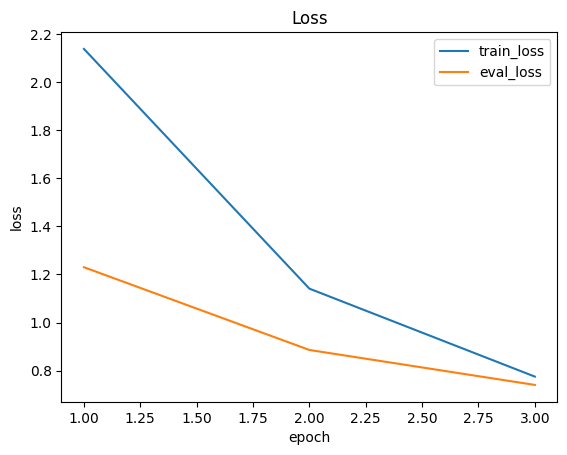

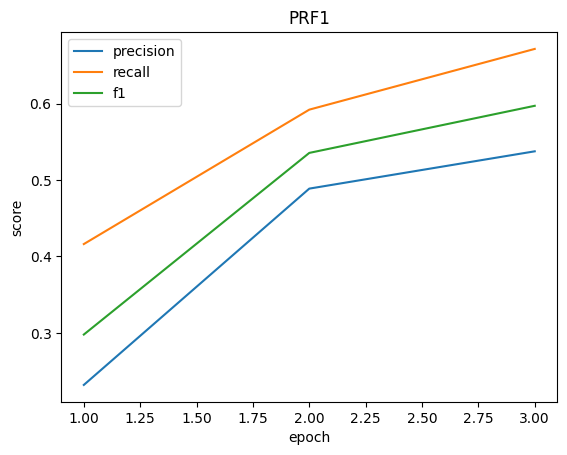

In [40]:
import matplotlib.pyplot as plt

# paste your table here
epochs   = [1, 2, 3]
train_l  = [2.138600, 1.140900, 0.774900]
eval_l   = [1.230069, 0.885762, 0.740297]
prec     = [0.231728, 0.488846, 0.537701]
rec      = [0.416216, 0.592278, 0.671815]
f1       = [0.297708, 0.535615, 0.597322]

plt.figure(); plt.plot(epochs, train_l, label="train_loss"); plt.plot(epochs, eval_l, label="eval_loss"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.show()
plt.figure(); plt.plot(epochs, prec, label="precision"); plt.plot(epochs, rec, label="recall"); plt.plot(epochs, f1, label="f1"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("score"); plt.title("PRF1"); plt.show()


In [42]:
# ===============================
# 📌 Cell R7': Trainer for 5 epochs
# ===============================
from transformers import TrainingArguments, Trainer
import os

RUN_DIR = os.path.join(OUTPUT_DIR, "llmv3_runs_5ep")

args = TrainingArguments(
    output_dir=RUN_DIR,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,   # effective batch size = 4
    num_train_epochs=5,              # 🔥 train 5 epochs
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    fp16=False,    # stay in FP32 for stability
    bf16=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=proc_train,
    eval_dataset=proc_val,
    data_collator=collator,
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting training for 5 epochs…")
train_out = trainer.train()
print(train_out)

save_dir = os.path.join(RUN_DIR, "final_model")
trainer.save_model(save_dir)
processor.save_pretrained(save_dir)

print("Saved model to:", save_dir)


/tmp/ipykernel_36/945712038.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for 5 epochs…


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.839000,0.702381,0.389501,0.572973,0.463750
2,0.571300,0.691222,0.397959,0.602317,0.479263
3,0.392900,0.539640,0.523460,0.715058,0.604439
4,0.305100,0.537130,0.575422,0.762934,0.656042
5,0.242100,0.516504,0.528555,0.728958,0.612788


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=420, training_loss=0.4651554618562971, metrics={'train_runtime': 376.3308, 'train_samples_per_second': 4.438, 'train_steps_per_second': 1.116, 'total_flos': 443298143754240.0, 'train_loss': 0.4651554618562971, 'epoch': 5.0})
Saved model to: /kaggle/working/dataset/llmv3_runs_5ep/final_model


In [43]:
# ===============================
# 📌 Cell PR1: Per-label P/R/F1 on validation
# ===============================
import numpy as np
from collections import defaultdict, Counter
from seqeval.metrics.sequence_labeling import get_entities

# 1) Get predictions on validation
pred = trainer.predict(proc_val)
pred_ids = np.argmax(pred.predictions, axis=-1)
true_ids = pred.label_ids

# 2) Convert id sequences -> tag strings (drop -100)
pred_tags, true_tags = [], []
for p_row, l_row in zip(pred_ids, true_ids):
    p_seq, l_seq = [], []
    for p_id, l_id in zip(p_row, l_row):
        if l_id == -100:
            continue
        p_seq.append(labels[p_id])
        l_seq.append(labels[l_id])
    pred_tags.append(p_seq)
    true_tags.append(l_seq)

# 3) Collapse BIO to entities per sentence
def to_entities(tag_seqs):
    # returns list of list of (type, start, end) tuples
    return [get_entities(seq) for seq in tag_seqs]

true_ents = to_entities(true_tags)
pred_ents = to_entities(pred_tags)

# 4) Count TP/FP/FN per label with exact span match
tp = Counter(); fp = Counter(); fn = Counter(); support = Counter()

for t_ents, p_ents in zip(true_ents, pred_ents):
    # sets of (type, start, end)
    t_set = set(t_ents)
    p_set = set(p_ents)

    # per-type support
    for (typ, s, e) in t_set:
        support[typ] += 1

    inter = t_set & p_set
    for (typ, s, e) in inter:
        tp[typ] += 1
    for (typ, s, e) in (p_set - inter):
        fp[typ] += 1
    for (typ, s, e) in (t_set - inter):
        fn[typ] += 1

# 5) Compute metrics per type
def safe_div(a, b): return (a / b) if b else 0.0

rows = []
all_types = sorted(set(list(tp.keys()) + list(fp.keys()) + list(fn.keys()) + list(support.keys())))
for typ in all_types:
    P = safe_div(tp[typ], tp[typ] + fp[typ])
    R = safe_div(tp[typ], tp[typ] + fn[typ])
    F1 = safe_div(2*P*R, P+R) if (P+R) else 0.0
    rows.append((typ, support[typ], P, R, F1))

# 6) Pretty print sorted by F1 desc
rows.sort(key=lambda x: x[4], reverse=True)
print(f"{'Label':22s} {'Support':>7s} {'P':>7s} {'R':>7s} {'F1':>7s}")
for typ, sup, P, R, F1 in rows:
    print(f"{typ:22s} {sup:7d} {P:7.3f} {R:7.3f} {F1:7.3f}")

# 7) Macro and micro averages
tot_tp = sum(tp.values()); tot_fp = sum(fp.values()); tot_fn = sum(fn.values())
micro_P = safe_div(tot_tp, tot_tp + tot_fp)
micro_R = safe_div(tot_tp, tot_tp + tot_fn)
micro_F1 = safe_div(2*micro_P*micro_R, micro_P+micro_R) if (micro_P+micro_R) else 0.0

macro_P = np.mean([safe_div(tp[t], tp[t]+fp[t]) if (tp[t]+fp[t]) else 0.0 for t in all_types]) if all_types else 0.0
macro_R = np.mean([safe_div(tp[t], tp[t]+fn[t]) if (tp[t]+fn[t]) else 0.0 for t in all_types]) if all_types else 0.0
macro_F1 = np.mean([safe_div(2*safe_div(tp[t], tp[t]+fp[t])*safe_div(tp[t], tp[t]+fn[t]),
                             safe_div(tp[t], tp[t]+fp[t])+safe_div(tp[t], tp[t]+fn[t])) if ((tp[t]+fp[t]) and (tp[t]+fn[t]) and (safe_div(tp[t], tp[t]+fp[t])+safe_div(tp[t], tp[t]+fn[t]))>0) else 0.0
                    for t in all_types]) if all_types else 0.0

print("\nMicro avg:  P={:.3f}  R={:.3f}  F1={:.3f}".format(micro_P, micro_R, micro_F1))
print("Macro avg:  P={:.3f}  R={:.3f}  F1={:.3f}".format(macro_P, macro_R, macro_F1))


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Label                  Support       P       R      F1
SUMMARY                     86   0.745   0.849   0.793
CONTACT                    123   0.682   0.821   0.745
EDUCATION                  221   0.616   0.769   0.684
LANGUES                     77   0.634   0.675   0.654
EXPERIENCE                 458   0.563   0.766   0.649
SKILLS                     202   0.475   0.708   0.569
PERSONAL_INFO               85   0.531   0.612   0.568
OTHERS                      37   0.022   0.054   0.031
PROJECTS/certifications       6   0.000   0.000   0.000

Micro avg:  P=0.529  R=0.729  F1=0.613
Macro avg:  P=0.474  R=0.584  F1=0.522
